## Random Jupyter Notebook to test functions and try local image attacks

In [12]:
! pip install line_profiler

In [38]:
from line_profiler import LineProfiler

In [39]:
import utils
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import torch.nn as nn
import json
import gzip


from utils import get_coarse_arrays, eliminate_elements_torch
from utils import ensamble_attack_coarse_classes_sum_full_v2

from PIL import Image, ImageEnhance
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#with open(os.path.join(res_path, 'results.json'), 'r') as json_file:
#    loaded_results = json.load(json_file)

#with gzip.open(os.path.join(res_path, 'results.json'), 'r') as f:
#    data2 = json.load(f)


In [31]:
file = r"C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\birds\Birds Selected\T up\Epsilon 8\images_folder_1_epsilon_8\results.json.gz"

In [2]:
from multiprocessing import Pool, cpu_count

In [4]:
res_path = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\Dogs Selected\T down\Epsilon 2\images_folder_115_epsilon_2'

In [5]:
with open(os.path.join(res_path, 'results.json'), 'r') as json_file:
    loaded_results = json.load(json_file)

loaded_results[0]['img_name']

'038642456454284.jpg'

In [13]:
classes = utils.get_imagenet_classes()
default_weights = utils.get_default_weights()
models_classif = utils.get_class_model_names()
models_ = utils.get_models_ensamble(models)
labels, index = get_coarse_arrays()

In [16]:
def generate_list(length, specified_positions, weights):
    weights = weights[0]
    output_list = [0] * length
    for i, pos in enumerate(specified_positions):
        output_list[pos] = weights[i]
    return output_list

def extract_and_normalize(original_probs, positions):
    # Extract values at specified positions
    extracted_values = original_probs[:, positions]
    # Sum of extracted values
    sum_values = torch.sum(extracted_values)
    # Normalize extracted values
    weights = extracted_values / sum_values
    return weights.tolist()

def extract_values(original_list, specified_indexes):
    # Use list comprehension to filter out values not corresponding to specified indexes
    extracted_values = [original_list[i] for i in range(len(original_list)) if i not in specified_indexes]
    return extracted_values

In [17]:
def randomize_phase_torch(image_tensor):
    # Convert torch tensor to NumPy array
    image_np = image_tensor.detach().numpy()

    # Separate color channels
    red_channel = image_np[:, 0, :, :]
    green_channel = image_np[:, 1, :, :]
    blue_channel = image_np[:, 2, :, :]

    # Compute FFT for each color channel
    red_fft = np.fft.fft2(red_channel, axes=(-2, -1))
    green_fft = np.fft.fft2(green_channel, axes=(-2, -1))
    blue_fft = np.fft.fft2(blue_channel, axes=(-2, -1))

    # Randomize phases for each color channel
    red_phases = np.angle(red_fft)
    green_phases = np.angle(green_fft)
    blue_phases = np.angle(blue_fft)

    randomized_g_phases = np.exp(1j * np.random.uniform(-np.pi, np.pi, red_phases.shape))
    randomized_green_phases = np.exp(1j * np.random.uniform(-np.pi, np.pi, green_phases.shape))
    randomized_blue_phases = np.exp(1j * np.random.uniform(-np.pi, np.pi, blue_phases.shape))

    # Combine magnitudes with randomized phases for each color channel
    randomized_red_fft = np.abs(red_fft) * randomized_g_phases
    randomized_green_fft = np.abs(green_fft) * randomized_g_phases
    randomized_blue_fft = np.abs(blue_fft) * randomized_g_phases

    # Compute the inverse FFT for each color channel
    randomized_red_channel = np.fft.ifft2(randomized_red_fft, axes=(-2, -1))
    randomized_green_channel = np.fft.ifft2(randomized_green_fft, axes=(-2, -1))
    randomized_blue_channel = np.fft.ifft2(randomized_blue_fft, axes=(-2, -1))

    # Take the abs to get the image for each color channel
    randomized_red_channel = np.abs(randomized_red_channel)
    randomized_green_channel = np.abs(randomized_green_channel)
    randomized_blue_channel = np.abs(randomized_blue_channel)

    # Combine color channels into RGB tensor
    randomized_image = np.stack((randomized_red_channel, randomized_green_channel, randomized_blue_channel), axis=1)
    randomized_image_plot = torch.from_numpy(randomized_image)

    print(f'Norma: {torch.norm(image_tensor)}, \nNorma: {torch.norm(randomized_image_plot)}')

    return randomized_image_plot

In [18]:
def ifgsm_attack(input, epsilon, data_grad, control = True, mode ='flip'):
    iter = int(min([epsilon + 4, epsilon * 1.25]))  # Number of iterations

    alpha = 1
    pert_out = input.clone().detach()

    for i in range(iter):
        pert_out = pert_out + (alpha / 255) * data_grad.sign()

        if torch.norm((pert_out - input), p=float('inf')) > epsilon / 255:
            break

    adv_pert = (pert_out - input)
    adv_pert_max = torch.max(adv_pert)
    adv_pert_min = torch.min(adv_pert)
    adv_pert_plot = (adv_pert - adv_pert_min)/(adv_pert_max - adv_pert_min)
    normalization = torch.mean(pert_out - input)

    pert_out_plot = pert_out

    if control == True:
        if mode == 'flip':
                       
                control_pert_lr = torch.flip(adv_pert_plot, [3]) #left - right
                control_pert_tb = torch.flip(adv_pert_plot, [2]) #top - bottom
                transposed_image = adv_pert_plot.transpose(2, 3)
                control_pert_diag = torch.flip(transposed_image, [2, 3]) #diagonal

                mse_right_left = F.mse_loss(input, control_pert_lr).item()
                mse_top_bottom = F.mse_loss(input, control_pert_tb).item()
                mse_diagonal = F.mse_loss(input, control_pert_diag).item()

                mse_values = {"Top-bottom": mse_top_bottom, "Diagonal": mse_diagonal, "Right-left": mse_right_left}
                max_mse_flipped_type = max(mse_values, key=mse_values.get)
                print(mse_values)
                                
                if max_mse_flipped_type == "Top-bottom":
                    control_pert_plot = control_pert_tb
                    control_pert = torch.flip(adv_pert, [3])
                    print('Control: Top Bottom')
                    control_image = control_pert + input

                elif max_mse_flipped_type == "Diagonal":
                    control_pert_plot = control_pert_diag
                                        
                    transposed_image = adv_pert.transpose(2, 3)
                    control_pert = torch.flip(transposed_image, [2, 3])
                    print('Control: Diagonal')
                    control_image = control_pert + input

                else:
                    control_pert_plot = control_pert_lr
                    control_pert = torch.flip(adv_pert, [2])
                    print('Control: Left Right')
                    control_image = control_pert + input


        elif mode == 'rndm':
                control_pert_plot =  randomize_phase_torch(adv_pert_plot)
                control_image = control_pert_plot*epsilon/255 + input
                control_image = control_image.float()

                print(adv_pert)
                print(control_pert_plot)
                
        return pert_out_plot, adv_pert_plot, control_image, control_pert_plot 
    else:
        return pert_out_plot, adv_pert_plot

In [ ]:
def ifgsm_attack_alternative(input, epsilon, data_grad, control = True, mode ='flip'):
    iter = 10  # Number of iterations

    alpha = epsilon/iter
    pert_out = input.clone().detach()

    for i in range(iter):
        pert_out = pert_out + (alpha / 255) * data_grad.sign()
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        eta = torch.clamp(perturbed_image - input, -epsilon/255, epsilon/255)
        perturbed_image = torch.clamp(input + eta, 0, 1)

    adv_pert = (pert_out - input)
    adv_pert_max = torch.max(adv_pert)
    adv_pert_min = torch.min(adv_pert)
    adv_pert_plot = (adv_pert - adv_pert_min)/(adv_pert_max - adv_pert_min)
    normalization = torch.mean(pert_out - input)

    pert_out_plot = pert_out

    if control == True:
        if mode == 'flip':
                       
                control_pert_lr = torch.flip(adv_pert_plot, [3]) #left - right
                control_pert_tb = torch.flip(adv_pert_plot, [2]) #top - bottom
                transposed_image = adv_pert_plot.transpose(2, 3)
                control_pert_diag = torch.flip(transposed_image, [2, 3]) #diagonal

                mse_right_left = F.mse_loss(input, control_pert_lr).item()
                mse_top_bottom = F.mse_loss(input, control_pert_tb).item()
                mse_diagonal = F.mse_loss(input, control_pert_diag).item()

                mse_values = {"Top-bottom": mse_top_bottom, "Diagonal": mse_diagonal, "Right-left": mse_right_left}
                max_mse_flipped_type = max(mse_values, key=mse_values.get)
                print(mse_values)
                                
                if max_mse_flipped_type == "Top-bottom":
                    control_pert_plot = control_pert_tb
                    control_pert = torch.flip(adv_pert, [3])
                    print('Control: Top Bottom')
                    control_image = control_pert + input

                elif max_mse_flipped_type == "Diagonal":
                    control_pert_plot = control_pert_diag
                                        
                    transposed_image = adv_pert.transpose(2, 3)
                    control_pert = torch.flip(transposed_image, [2, 3])
                    print('Control: Diagonal')
                    control_image = control_pert + input

                else:
                    control_pert_plot = control_pert_lr
                    control_pert = torch.flip(adv_pert, [2])
                    print('Control: Left Right')
                    control_image = control_pert + input


        elif mode == 'rndm':
                control_pert_plot =  randomize_phase_torch(adv_pert_plot)
                control_image = control_pert_plot*epsilon/255 + input
                control_image = control_image.float()

                print(adv_pert)
                print(control_pert_plot)
                
        return pert_out_plot, adv_pert_plot, control_image, control_pert_plot 
    else:
        return pert_out_plot, adv_pert_plot

In [41]:
def ensamble_attack_coarse_classes_sum_full(image_folder, models, weights, epsilon, classes, targeted = False, t = '0', coarse_class = 'nada', num_classes=1000, graph=False, folder=False, sorted = True,  attack = 'iFGSM',save_path = 0, control = True):
    """Test function to generate adversarial images and obtain predictions using an ensemble of models."""

    c_classes, c_index = get_coarse_arrays() 


    for model in models:
        model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Prepare output directory
    if folder:
        if save_path == 0:
            if targeted == False:
                output_dir = f"ensamble-attack_ensamble-c_epsilon-{epsilon}-untargeted"
            else:
                output_dir = f"ensamble-attack_ensamble-c_epsilon-{epsilon}-targeted"
            
            os.makedirs(output_dir, exist_ok=True)
        else:
            output_dir = save_path

    results = []
    control = []
    print('Iterating over images in folder\n\n')
    
    for i, image_name in enumerate(os.listdir(image_folder)):
        image_path = os.path.join(image_folder, image_name)
        print(f'\n\nImage {i + 1}/{len(os.listdir(image_folder))}--------------------------------------------------------\nImage name:{image_name}')

        # Load and transform image
        img = Image.open(image_path)
        transformed_image = weights(img).unsqueeze(0)
        original_image = transformed_image.clone()

        # Calculate ensemble predictions
        ensemble_outputs = []
        transformed_image.requires_grad = True
        for model in models:
            model.eval()

        try:
            output = model(normalize(transformed_image))
            ensemble_outputs.append(output)

        except RuntimeError as e:
            if "output with shape [1, 1, 256, 256] doesn't match the broadcast shape [1, 3, 256, 256]" in str(e):
                print("Encountered specific RuntimeError. Moving to next element.")
                continue

        ensemble_outputs = torch.stack(ensemble_outputs)
        ensemble_mean_output = torch.mean(ensemble_outputs, dim=0)

        # Get original predictions
        original_output = ensemble_mean_output.clone()
        original_probs = torch.softmax(original_output, dim=1)

        # Calculate loss
        loss = nn.CrossEntropyLoss()

        if targeted == True:
            if type(t) == str:
                target = original_output.max(1)[1]   #maximize original output
                cost = -loss(original_output, target)
            elif type(t) == int:
                target = torch.tensor([t])           #maximize target t
                cost = -loss(original_output, target)

            elif type(t) == np.ndarray or type(t) == list:
                w = extract_and_normalize(original_probs, t)
                probs_t = generate_list(1000, t, w)
                target = torch.tensor([probs_t])           
                cost = -loss(original_output, target)
        else:
            if type(t) != str:
                non_t = extract_values(np.arange(1000), t)
                w = extract_and_normalize(original_probs, non_t)
                probs_t = generate_list(1000, non_t, w)
                target = torch.tensor([probs_t])           
                cost = -loss(original_output, target)
            else:
                target = original_output.max(1)[1]
                cost = loss(original_output, target)  #minimize original output

        #Calculate grad
        for model in models:
            model.zero_grad()

        #loss.backward()
        grad = torch.autograd.grad(cost, transformed_image)[0]

        # Generate adversarial image
        if control == True:
            perturbed_image, adv_pert, control_image, control_pert = ifgsm_attack(transformed_image, epsilon, grad, control = True)
        else:
            perturbed_image, adv_pert = ifgsm_attack(transformed_image, epsilon, grad, control = False)
        # Get perturbed predictions
        perturbed_output = torch.mean(torch.stack([model(normalize(perturbed_image)) for model in models]), dim=0)
        perturbed_probs = torch.softmax(perturbed_output, dim=1)

        if control == True:
            control_output = torch.mean(torch.stack([model(normalize(control_image)) for model in models]), dim=0)
            control_probs = torch.softmax(control_output, dim=1)

        # Compute coarse category scores
        #print('Fine Class --> Coarse class')

        scores_original = torch.zeros(size= (len(c_index),))
        scores_perturbed = torch.zeros(size= (len(c_index),))
        if control == True:
            scores_control = torch.zeros(size= (len(c_index),))

        for i in np.arange(len(c_index)): #Iterate in the coarse classes

            c = c_index[i] #coarse class indexs

            c_values = original_probs[:, c]
            sum = torch.sum(c_values)
            scores_original[i] = sum

            c_values_p = perturbed_probs[:, c]
            sum_p = torch.sum(c_values_p)
            scores_perturbed[i] = sum_p
            
            if control == True:
                c_values_c = control_probs[:, c]
                sum_c = torch.sum(c_values_c)
                scores_control[i] = sum_c

        #Eliminate values of probs (perturbed and original)
        coarse_idx = np.hstack(c_index) #index to eliminate
        coarse_scores = eliminate_elements_torch(original_probs[0], coarse_idx)
        pert_coarse_scores = eliminate_elements_torch(perturbed_probs[0], coarse_idx)
        if control == True:
            ctrl_coarse_scores = eliminate_elements_torch(control_probs[0], coarse_idx)

        new_classes = [string for idx, string in enumerate(classes) if idx not in coarse_idx]

        #Concat new scores and new list of classes
        coarse_scores = torch.cat((coarse_scores, scores_original), dim = 0)
        pert_coarse_scores = torch.cat((pert_coarse_scores,  scores_perturbed), dim = 0)
        if control == True:
            ctrl_coarse_scores = torch.cat((ctrl_coarse_scores,  scores_control), dim = 0)

        new_classes = new_classes + c_classes

        sorted_probs_p, sorted_indices_p = torch.sort(pert_coarse_scores, descending=True)
        sorted_classes_p = [new_classes[i] for i in sorted_indices_p]

        sorted_probs, sorted_indices = torch.sort(coarse_scores, descending=True)
        sorted_classes = [new_classes[i] for i in sorted_indices]

        if folder:
            if len(t) > 1:
                a = targeted == True #Targeted
                b = coarse_class != sorted_classes_p[0] #Targeted Class not equal to Top Class obtained

                c = targeted == False #Not Targeted --> Original output equal to top class
                d = coarse_class == sorted_classes_p[0] #Targeted Class not equal to Top Class obtained

                e = coarse_class == sorted_classes[0] #Make sure that when I iterate over a random set of images, if I expect to have a true class T, and adv class A, these are not the same

                print(coarse_class, sorted_classes_p[0])
                if  (a and b) or (c and d):
                    print('Not verify the conditions expected')
                    continue
                elif e:
                    print('Verify condition but the T (true) class is = to A (adv) class')
                    continue

        # Sort predictions
        original_top_classes = original_probs[0].topk(num_classes)
        perturbed_top_classes = perturbed_probs[0].topk(num_classes)
        if control == True:
            control_top_classes = control_probs[0].topk(num_classes)

        original_dict = {classes[idx.item()]: prob.item() for idx, prob in zip(original_top_classes.indices, original_top_classes.values)}
        perturbed_dict = {classes[idx.item()]: prob.item() for idx, prob in zip(perturbed_top_classes.indices, perturbed_top_classes.values)}
        if control == True:
            control_dict = {classes[idx.item()]: prob.item() for idx, prob in zip(control_top_classes.indices, control_top_classes.values)}

        #sorting values 

    
        if control == True:
            sorted_probs_c, sorted_indices_c = torch.sort(ctrl_coarse_scores, descending=True)
            sorted_classes_c = [new_classes[i] for i in sorted_indices_c]

        #define dicts with probs
        probs_scores = {}
        for key, value in zip(sorted_classes, sorted_probs):
            probs_scores[key] = value.item() 

        probs_p_scores = {}
        for key, value in zip(sorted_classes_p, sorted_probs_p):
            probs_p_scores[key] = value.item() 

        if control == True:
            probs_c_scores = {}
            for key, value in zip(sorted_classes_c, sorted_probs_c):
                probs_c_scores[key] = value.item() 

        results.append({'img_name': image_name, 'original': original_dict, 'perturbed': perturbed_dict, 'coarse_scores': probs_scores, 'pert_coarse_scores': probs_p_scores})
        
        if control == True:
            control.append({'ctrl': control_dict, 'ctrl_scores': probs_c_scores})

        #print(probs_c_scores)

        # Save adversarial image
        if folder:
            counter = 1
            perturbed_image = perturbed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
            perturbed_image = np.clip(perturbed_image, 0,1)
            perturbed_image = (perturbed_image * 255).astype('uint8')

            adv_pert = adv_pert.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
            adv_pert =  np.clip(adv_pert, 0, 1)
            adv_pert = (adv_pert * 255).astype('uint8')

            if control == True:
                control_image = control_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
                control_image = np.clip(control_image, 0, 1)
                control_image = (control_image * 255).astype('uint8')

                control_pert = control_pert.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
                control_pert = np.clip(control_pert, 0,1 )
                control_pert = (control_pert * 255).astype('uint8')

            while True:
                # Generate folder name
                folder_name = f"images_folder_{counter}_epsilon_{epsilon}"
                folder_path = os.path.join(output_dir, folder_name)

                # Check if folder already exists
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                    break
                else:
                    counter += 1

            atk_path = os.path.join(folder_path, 'atk.png')
            Image.fromarray(perturbed_image).resize((720,720)).save(atk_path, optimize=True)
            pert_path = os.path.join(folder_path, 'pert.png')
            Image.fromarray(adv_pert).resize((720,720)).save(pert_path, optimize=True)

            if control == True:
                control_pert_path = os.path.join(folder_path, 'control_pert.png')
                Image.fromarray(control_pert).resize((720,720)).save(control_pert_path, optimize=True)
                control_path = os.path.join(folder_path, 'control.png')
                Image.fromarray(control_image).resize((720,720)).save(control_path, optimize=True)

            with gzip.open(os.path.join(folder_path, 'results.json.gz'), 'wt') as f:
                json.dump(results, f)

            if control == True:
                with gzip.open(os.path.join(folder_path, 'control.json.gz'), 'wt') as f:
                    json.dump(control, f)

            if (a & b):
                print('SAVED IMAGE. Equal Target as Top Perturbed')
            elif (c & d):
                print('SAVED IMAGE. Different Top Perturbed from Original')


        print(f'Epsilon: {epsilon}')
        if targeted == True:
            if type(t) == str:
                print(f'Targeted Attack. Maximize Original Output\nOriginal prob: {probs_scores[sorted_classes[0]]},\nPerturbed prob: {probs_p_scores[sorted_classes[0]]}\nControl prob: {probs_c_scores[sorted_classes[0]]}')
            elif len(t) == 1:
                print(f'Targeted Attack = {classes[t[0]]}\nOriginal prob target: {probs_scores[classes[t[0]]]},\nPerturbed prob target: {probs_p_scores[classes[t[0]]]}\nControl prob target: {probs_c_scores[classes[t[0]]]}')
            elif len(t) > 1:
                print(f'Targeted Attack = {coarse_class}\nOriginal prob target: {probs_scores[coarse_class]},\nPerturbed prob target: {probs_p_scores[coarse_class]},\nPerturbed Top class & Prob: {sorted_classes_p[0]} & {sorted_probs_p[0]}')
                if control == True:
                    print(f'\nControl prob target: {probs_c_scores[coarse_class]}')
        else:
            print(f'Untargeted Attack. Minimize Original Output\nOriginal prob target: {probs_scores[sorted_classes[0]]},\nPerturbed prob target: {probs_p_scores[sorted_classes[0]]},\nPerturbed Top class & Prob: {sorted_classes_p[0]} & {sorted_probs_p[0]}\nControl prob target: {probs_c_scores[sorted_classes[0]]}')

        if graph:
            if folder != True:
                perturbed_image = perturbed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
                adv_pert_plot = adv_pert.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

                if control == True:
                    control_image = control_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
                    control_pert = control_pert.squeeze().detach().cpu().numpy().transpose(1, 2, 0)


            if control == True:
                f, axs = plt.subplots(1, 3, figsize=(17, 5))
                axs[0].imshow(original_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
                axs[0].set_title(f"Original: {max(original_dict, key=original_dict.get)} - {np.round(max(original_dict.values()), 3)}" + "\n" + f"Original: {max(probs_scores, key=probs_scores.get)} - {np.round(max(probs_scores.values()), 3)}", fontsize=7)
                axs[0].set_axis_off()

                axs[1].imshow(np.clip(perturbed_image, 0, 1))
                axs[1].set_title(f"Perturbed: {max(perturbed_dict, key=perturbed_dict.get)} - {np.round(max(perturbed_dict.values()), 3)}" + "\n" + f"Perturbed: {max(probs_p_scores, key=probs_p_scores.get)} - {np.round(max(probs_p_scores.values()), 3)}", fontsize=7)
                axs[1].set_axis_off()

                axs[2].imshow(np.clip(control_image, 0, 1))
                axs[2].set_title(f"Control Image: {max(control_dict, key=control_dict.get)} - {np.round(max(control_dict.values()), 3)}" + "\n" + f"Control: {max(probs_c_scores, key=probs_c_scores.get)} - {np.round(max(probs_c_scores.values()), 3)}", fontsize=7)
                axs[2].set_axis_off() 

                plt.subplots_adjust(wspace=0.5)  # Add space between the plots
                plt.show()

                plt.subplot(1, 2, 1)
                plt.imshow(adv_pert_plot)
                plt.title(f"Perturbation", fontsize=7)
                plt.axis('off') 

                plt.subplot(1, 2, 2)
                plt.imshow(np.clip(control_pert, 0, 1))
                plt.title(f"Perturbation - Control", fontsize=7)
                plt.axis('off') 

                plt.subplots_adjust(wspace=0.5)  # Add space between the plots
                plt.show()
            
            else:
                f, axs = plt.subplots(1, 3, figsize=(17, 5))
                axs[0].imshow(original_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
                axs[0].set_title(f"Original: {max(original_dict, key=original_dict.get)} - {np.round(max(original_dict.values()), 3)}" + "\n" + f"Original: {max(probs_scores, key=probs_scores.get)} - {np.round(max(probs_scores.values()), 3)}", fontsize=7)
                axs[0].set_axis_off()

                axs[1].imshow(np.clip(perturbed_image, 0, 1))
                axs[1].set_title(f"Perturbed: {max(perturbed_dict, key=perturbed_dict.get)} - {np.round(max(perturbed_dict.values()), 3)}" + "\n" + f"Perturbed: {max(probs_p_scores, key=probs_p_scores.get)} - {np.round(max(probs_p_scores.values()), 3)}", fontsize=7)
                axs[1].set_axis_off()

                axs[2].imshow(np.clip(adv_pert_plot, 0, 1))
                axs[2].set_title(f"Perturbation", fontsize=7)
                axs[2].set_axis_off() 

                plt.subplots_adjust(wspace=0.5)  # Add space between the plots
                plt.show()

    return results

In [7]:
labels, index = get_coarse_arrays()

In [9]:
tabby = r"C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\tabby cat 2"
tiger = r"C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\tiger cat 2"
persian = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\persian cat 2'
egyptian = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\egyptian cat 2'
siamese = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\siamese cat 2'
tabby2 = r"C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\tabby cat"
tiger2 = r"C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\tiger cat"
persian2 = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\persian cat'
egyptian2 = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\egyptian cat'
siamese2 = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\siamese cat'

cats_folders = [tabby2, tabby, tiger, persian, egyptian, tiger2, persian2, egyptian2, siamese2, siamese]

In [11]:
birds_folders = []

for i in range(1, 5):
    birds_folders.append(rf"C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\birds\birds {i}")

dogs_folders = []

for i in range(1, 6):
    dogs_folders.append(rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\dogs {i}')


### Show different controls - Flip vs Random Phase

In [7]:
dogs_folders_test = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\d_test']

In [14]:
parallel_attak(dogs_folders_test[0], models_, default_weights, 16, classes, targeted=False, t = index[1], coarse_class='dog', graph= True)

Iterating over images in folder




Iterating over images in folder




Image 1/2--------------------------------------------------------
Image name:test_1.jpeg
{'Top-bottom': 0.30028972029685974, 'Diagonal': 0.29930445551872253, 'Right-left': 0.2994920015335083}
Top Bottom
Epsilon: 16
Untargeted Attack. Minimize Original Output
Original prob target: 0.9982558488845825,
Perturbed prob target: 0.9870798587799072,
Perturbed Top class & Prob: dog & 0.9870798587799072
Control prob target: 0.9987930655479431


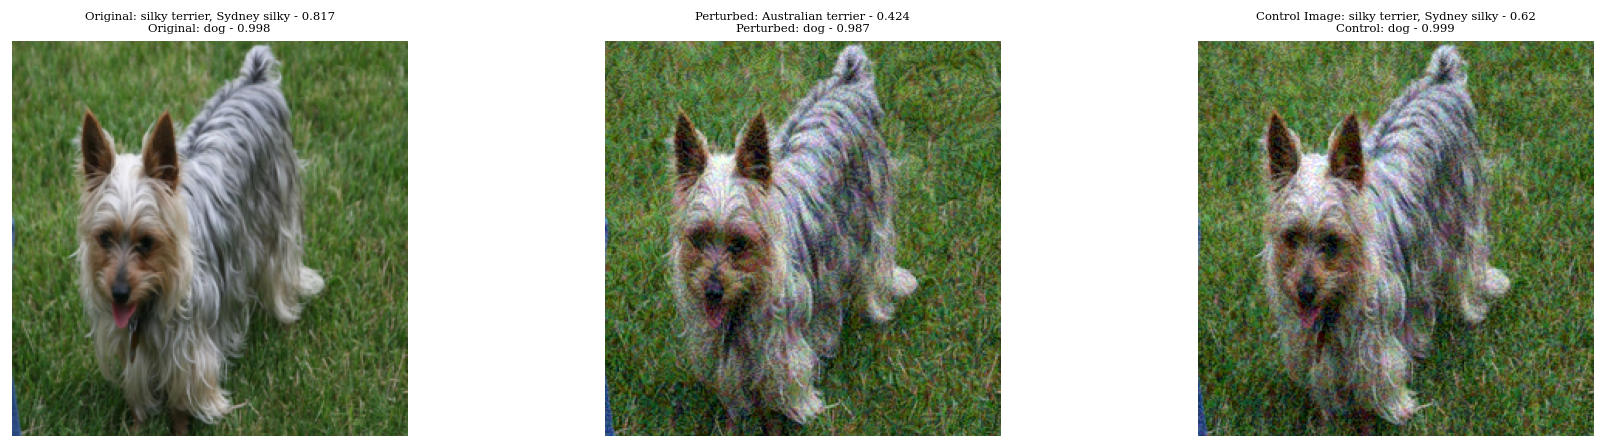

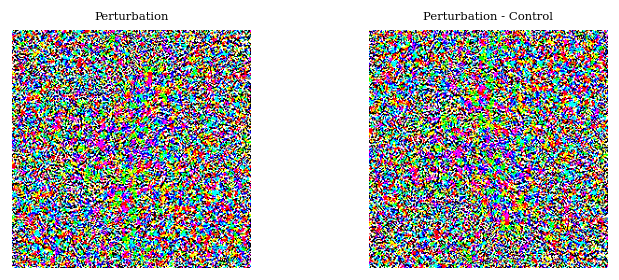



Image 2/2--------------------------------------------------------
Image name:test_2.jpeg
{'Top-bottom': 0.2960472106933594, 'Diagonal': 0.2954849302768707, 'Right-left': 0.29519468545913696}
Top Bottom
Epsilon: 16
Untargeted Attack. Minimize Original Output
Original prob target: 0.9481973648071289,
Perturbed prob target: 0.662164032459259,
Perturbed Top class & Prob: dog & 0.662164032459259
Control prob target: 0.8170934319496155


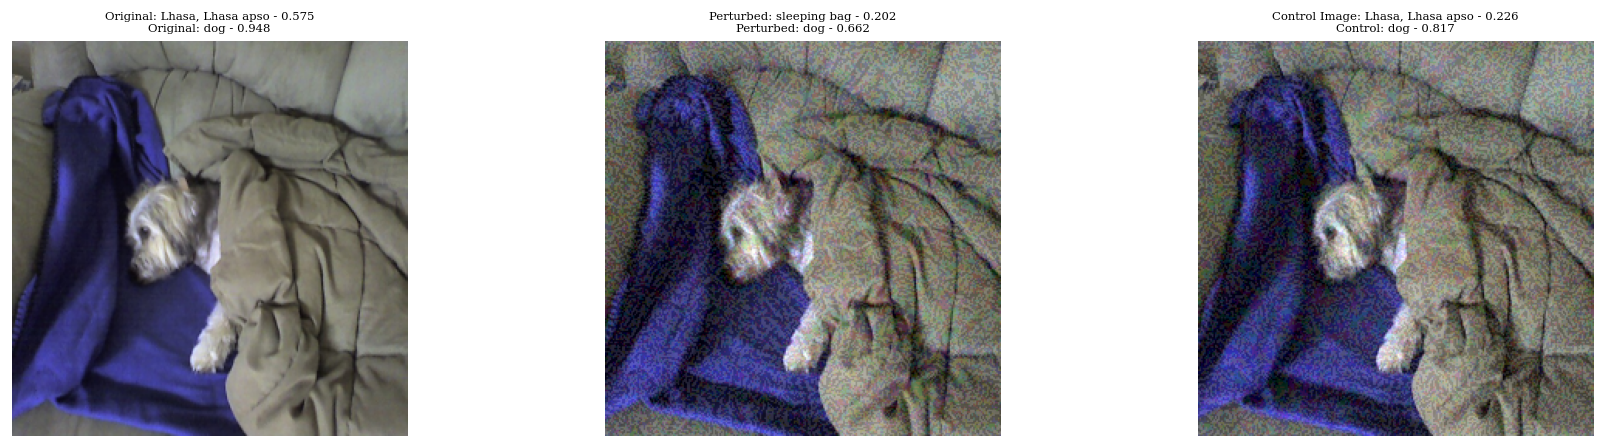

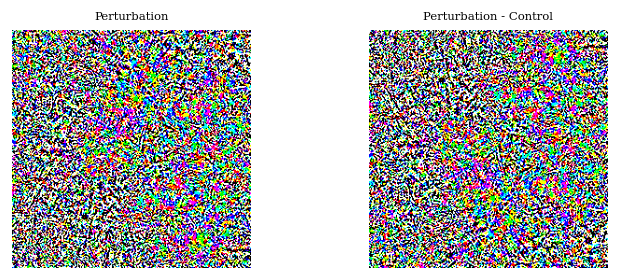

In [17]:
num_processes = min(cpu_count(), 4)  # Limit to 4 processes or the number of CPU cores available

test = ensamble_attack_coarse_classes_sum_full(dogs_folders_test[0], models_, default_weights, 16, classes, targeted=False, t = index[1], coarse_class='dog', graph= True)

### a) Image Net

In [27]:
birds_folders_imagenet = []

for i in range(85, 87):
    d = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\class_images_image_net\000{i}'
    birds_folders_imagenet.append(d)

In [22]:
birds_folders = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\birds\Birds Down']

In [37]:
for eps in [8, 16]: 
    save_birds = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\birds\Birds Selected\T up\Epsilon {eps}'
    for birds_f in birds_folders:
        test = ensamble_attack_coarse_classes_sum_full(birds_f, models_, default_weights, eps, classes, targeted=True, t = index[2], coarse_class='bird', graph= False, folder = True, save_path=save_birds, control = False)

Iterating over images in folder




Image 1/143--------------------------------------------------------
Image name:0165945954573035.jpg
bird bird
Epsilon: 8
Targeted Attack = bird
Original prob target: 0.9968427419662476,
Perturbed prob target: 0.9999393224716187,
Perturbed Top class & Prob: bird & 0.9999393224716187


Image 2/143--------------------------------------------------------
Image name:018005195043613.jpg
bird bird
Epsilon: 8
Targeted Attack = bird
Original prob target: 0.9978233575820923,
Perturbed prob target: 0.9997985363006592,
Perturbed Top class & Prob: bird & 0.9997985363006592


Image 3/143--------------------------------------------------------
Image name:032211073884996.jpg
bird bird
Epsilon: 8
Targeted Attack = bird
Original prob target: 0.9950623512268066,
Perturbed prob target: 0.9991865754127502,
Perturbed Top class & Prob: bird & 0.9991865754127502


Image 4/143--------------------------------------------------------
Image name:041169091493441.jpg
bird bird
Ep

### 1. Cats

In [ ]:
for eps in [8, 16]: 
    save_cats = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\Selected Cats\T down\Epsilon {eps}'
    for cats_f in cats_folders:
        test = ensamble_attack_coarse_classes_sum_full(cats_f, models_, default_weights, eps, classes, targeted=False, t = index[0], coarse_class='cat', graph= False, folder = True, save_path=save_cats)

### 2. Dogs

In [36]:
from line_profiler import LineProfiler

In [51]:
dogs_folders = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\dogs 9']

In [ ]:
lp = LineProfiler()
lp.add_function(ensamble_attack_coarse_classes_sum_full)
save_dogs = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\Dogs Selected\T down\Epsilon 2'
lp.runcall(ensamble_attack_coarse_classes_sum_full, dogs_folders_test[0], models_, default_weights, 2, classes, targeted=False, t = index[1], coarse_class='dog', graph= False, folder = True, save_path=save_dogs)
lp.print_stats()

In [14]:
dogs_folders = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\d_down\Eps 2']

In [15]:
for eps in [2, 8, 16]: 
    save_dogs = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\dogs\Dogs Selected\T up\Epsilon {eps}'
    for dogs_f in dogs_folders:
        test = ensamble_attack_coarse_classes_sum_full(dogs_f, models_, default_weights, eps, classes, targeted=True, t = index[1], coarse_class='dog', graph= False, folder = True, save_path=save_dogs)

Iterating over images in folder




Image 1/133--------------------------------------------------------
Image name:038642456454284.jpg
{'Top-bottom': 0.3475518524646759, 'Diagonal': 0.3483933210372925, 'Right-left': 0.3471050560474396}
Control: Diagonal
dog dog
Epsilon: 2
Targeted Attack = dog
Original prob target: 0.9872878193855286,
Perturbed prob target: 0.9999487996101379,
Perturbed Top class & Prob: dog & 0.9999487996101379
Control prob target: 0.9821997284889221


Image 2/133--------------------------------------------------------
Image name:044432343333379.jpg
{'Top-bottom': 0.36050549149513245, 'Diagonal': 0.36050334572792053, 'Right-left': 0.36082473397254944}
Control: Left Right
dog dog
Epsilon: 2
Targeted Attack = dog
Original prob target: 0.992933988571167,
Perturbed prob target: 0.9999710321426392,
Perturbed Top class & Prob: dog & 0.9999710321426392
Control prob target: 0.9867256283760071


Image 3/133--------------------------------------------------------
Image name:044

### 3. Birds

In [11]:
birds_folders = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\birds\birds 5']

In [ ]:
for eps in [2, 4, 8, 16]: 
    save_birds = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\birds\Birds Selected\T down\Epsilon {eps}'
    for birds_f in birds_folders:
        test = ensamble_attack_coarse_classes_sum_full(birds_f, models_, default_weights, eps, classes, targeted=False, t = index[2], coarse_class='bird', graph= False, folder = True, save_path=save_birds)

### 4. Bottles

In [39]:
water_bottle = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\bottles\water bottle 2'
wine_bottle = r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\bottles\wine bottle 2'

bottle_folders = [water_bottle, wine_bottle]

In [16]:
bottle_folders = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\bottles\bottles_down']

In [17]:
for eps in [2, 4, 8, 16]: 
    save_bottles = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\bottles\Bottles Selected\T up\Epsilon {eps}'
    for bottle_f in bottle_folders:
        test = ensamble_attack_coarse_classes_sum_full(bottle_f, models_, default_weights, eps, classes, targeted=True, t = index[3], coarse_class='bottle', graph= False, folder = True, save_path=save_bottles)

Iterating over images in folder




Image 1/69--------------------------------------------------------
Image name:n02823428_10128.jpeg
{'Top-bottom': 0.4537203311920166, 'Diagonal': 0.45189225673675537, 'Right-left': 0.4528120458126068}
Control: Top Bottom
bottle bottle
Epsilon: 2
Targeted Attack = bottle
Original prob target: 0.06939651817083359,
Perturbed prob target: 0.5579347014427185,
Perturbed Top class & Prob: bottle & 0.5579347014427185
Control prob target: 0.05681648850440979


Image 2/69--------------------------------------------------------
Image name:n02823428_104.JPEG
{'Top-bottom': 0.32861757278442383, 'Diagonal': 0.33001503348350525, 'Right-left': 0.32890042662620544}
Control: Diagonal
bottle bottle
Epsilon: 2
Targeted Attack = bottle
Original prob target: 0.823896586894989,
Perturbed prob target: 0.9951435923576355,
Perturbed Top class & Prob: bottle & 0.9951435923576355
Control prob target: 0.7807296514511108


Image 3/69-----------------------------------------------

In [26]:
cats_folders = [r'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\t_down']

In [27]:
for eps in [16]: 
    save_cats = rf'C:\Users\Usuario\Documents\Trini\Facultad\Tesis\Código Personal\image_net\cats\Selected Cats\T up\Epsilon {eps}'
    for cats_f in cats_folders:
        test = ensamble_attack_coarse_classes_sum_full(cats_f, models_, default_weights, eps, classes, targeted=True, t = index[0], coarse_class='cat', graph= False, folder = True, save_path=save_cats)

Iterating over images in folder




Image 1/129--------------------------------------------------------
Image name:n02123045_10088.JPEG
{'Top-bottom': 0.2868543863296509, 'Diagonal': 0.28747984766960144, 'Right-left': 0.28766998648643494}
Control: Left Right
cat cat
Epsilon: 16
Targeted Attack = cat
Original prob target: 0.9049239158630371,
Perturbed prob target: 0.9964703917503357,
Perturbed Top class & Prob: cat & 0.9964703917503357
Control prob target: 0.8390955924987793


Image 2/129--------------------------------------------------------
Image name:n02123045_101.JPEG
{'Top-bottom': 0.33573293685913086, 'Diagonal': 0.33474674820899963, 'Right-left': 0.33585646748542786}
Control: Left Right
cat cat
Epsilon: 16
Targeted Attack = cat
Original prob target: 0.6969701647758484,
Perturbed prob target: 0.9795388579368591,
Perturbed Top class & Prob: cat & 0.9795388579368591
Control prob target: 0.8646541237831116


Image 3/129--------------------------------------------------------
Image n